In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import functools
import math

In [0]:
seed = 42
BATCH_SIZE = 32
num_epochs = 100
scale_factor = 4

In [4]:
hands_builder = tfds.builder('rock_paper_scissors')
hands_builder.download_and_prepare()

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incomplete0VNRDI/rock_paper_scissors-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incomplete0VNRDI/rock_paper_scissors-test.tfrecord


Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


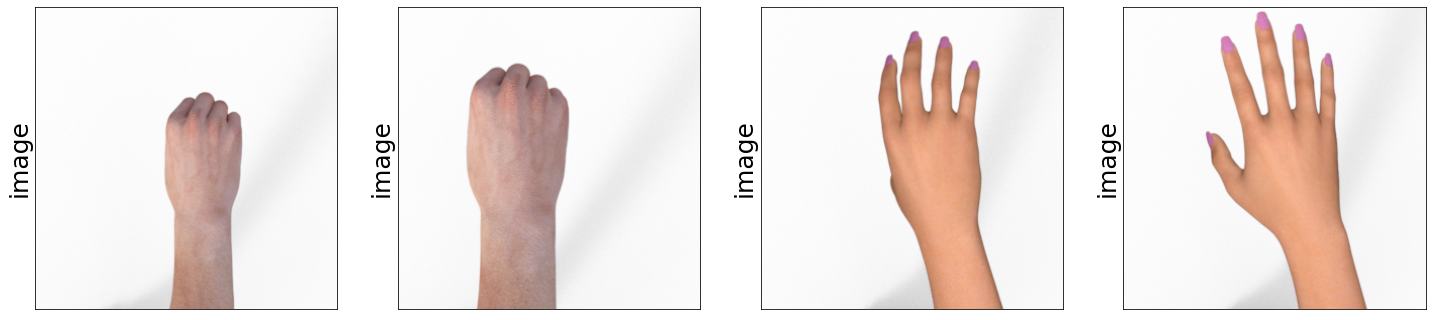

In [5]:
from plotting import plot_image_grid
num_show = 4

hands_val_dataset = hands_builder.as_dataset(split=tfds.Split.TEST).batch(num_show)
hands_val_dataset_iter = hands_val_dataset.skip(1).__iter__()

batch = next(hands_val_dataset_iter)

fig = plot_image_grid([batch['image'].numpy()], titles=['image'], transpose=True)
fig.show()

In [0]:
def _prepare_data_fn(features, scale_factor=4, augment=True,
                    return_batch_as_tuple=True, seed=None):
    
    image = features['image']
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    original_shape = tf.shape(image)
    original_size = original_shape[-3:-1]
    scaled_size = original_size // scale_factor
    
    original_size_mult = scaled_size * scale_factor
    
    if augment:
        original_shape_mult = (original_size_mult, [tf.shape(image)[-1]])
        if len(image.shape) > 3:
            original_shape_mult = ([tf.shape(image)[0]], *original_shape_mult)
        original_shape_mult = tf.concat(original_shape_mult, axis=0)
        
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, max_delta=0.1, seed=seed)
        image = tf.image.random_saturation(image, lower=0.5, upper=1.5, seed=seed)
        image = tf.clip_by_value(image, 0.0, 1.0)
        
        random_scale_factor = tf.random.uniform([1], minval=1.0, maxval=1.2,
                                                dtype=tf.float32, seed= seed)
        scaled_height = tf.cast(tf.multiply(tf.cast(original_size[0], tf.float32),
                                           random_scale_factor),
                               tf.int32)
        scaled_width = tf.cast(tf.multiply(tf.cast(original_size[1], tf.float32),
                                          random_scale_factor),
                              tf.int32)
        scaled_shape = tf.squeeze(tf.stack([scaled_height, scaled_width]))
        image = tf.image.resize(image, scaled_shape)
        image = tf.image.random_crop(image, original_shape, seed=seed)
    
    image_downscaled = tf.image.resize(image, scaled_size)
    
    original_size_mult = scaled_size * scale_factor
    image = tf.image.resize(image, original_size_mult)
    
    features = (image_downscaled, image) if return_batch_as_tuple else {'image': image_downscaled,
                                                                       'label': image}
    
    return features

In [0]:
def get_hands_dataset_for_superres(phase='train', scale_factor=4, batch_size=32,
                                  num_epochs=None, shuffle=True, augment=False,
                                  return_batch_as_tuple=True, seed=None):
    
    assert(phase=='train' or phase == 'test')
    
    prepare_data_fn = functools.partial(
        _prepare_data_fn, scale_factor=scale_factor, augment=augment,
        return_batch_as_tuple=return_batch_as_tuple, seed=seed
    )
    
    superres_dataset = hands_builder.as_dataset(
        split=tfds.Split.TRAIN if phase == 'train' else tfds.Split.TEST
    )
    
    superres_dataset = superres_dataset.repeat(num_epochs)
    
    if shuffle:
        superres_dataset = superres_dataset.shuffle(
            hands_builder.info.splits[phase].num_examples, seed=seed
        )
    
    superres_dataset = superres_dataset.batch(batch_size)
    superres_dataset = superres_dataset.map(prepare_data_fn, num_parallel_calls=4)
    superres_dataset = superres_dataset.prefetch(1)
    
    return superres_dataset

In [0]:
num_train_imgs = hands_builder.info.splits['train'].num_examples
num_val_imgs = hands_builder.info.splits['test'].num_examples

In [0]:
train_steps_per_epoch = math.ceil(num_train_imgs / BATCH_SIZE)
val_steps_per_epoch = math.ceil(num_val_imgs / BATCH_SIZE)

In [0]:
input_shape = hands_builder.info.features['image'].shape

In [0]:
train_hands_dataset = get_hands_dataset_for_superres(
    phase='train', scale_factor=scale_factor, batch_size=BATCH_SIZE, 
    num_epochs=num_epochs, augment=True, shuffle=True, seed = seed
)

val_hands_dataset = get_hands_dataset_for_superres(
    phase = 'test', scale_factor=scale_factor, batch_size=BATCH_SIZE,
    num_epochs=1, augment=False, shuffle=False, seed=seed
)

PSNR for each pair: [35.45046  35.33622  30.630665 30.230751]


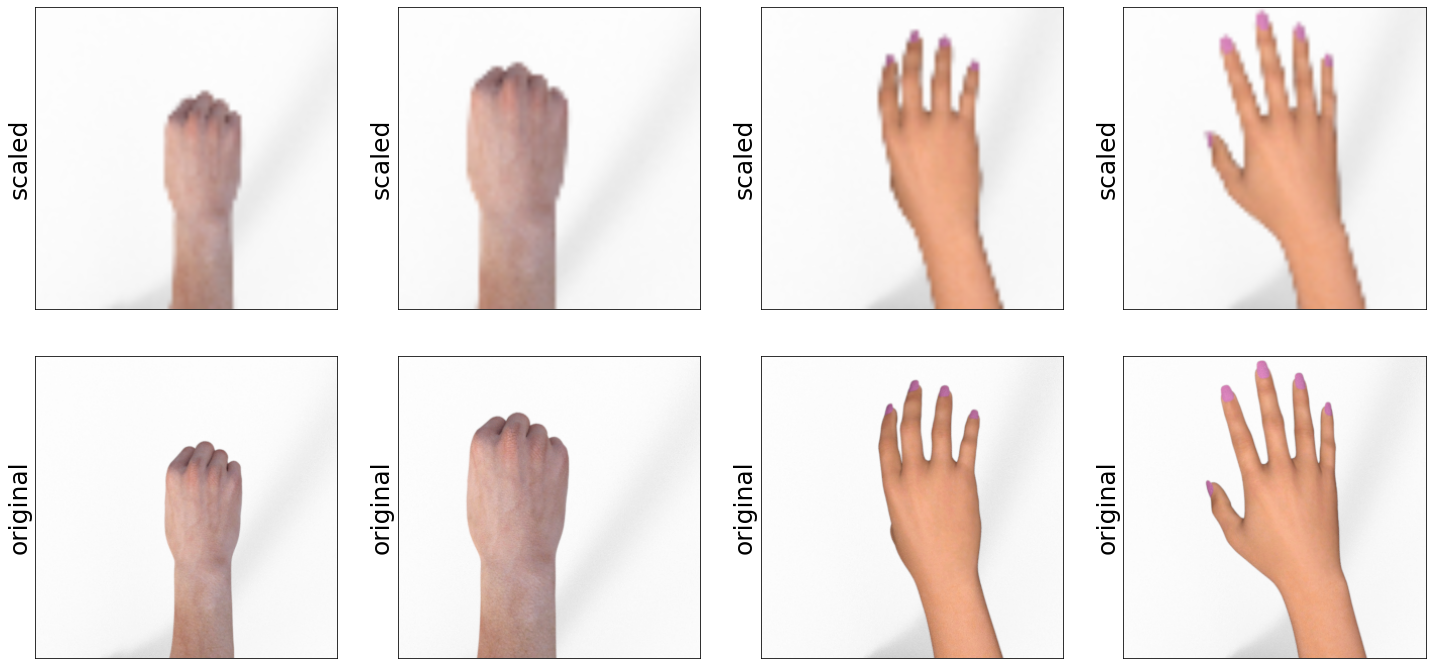

In [12]:
from plotting import plot_image_grid

val_hands_dataset_show = val_hands_dataset.take(1)
val_images_input, val_images_target = next(val_hands_dataset_show.__iter__())
val_images_input = val_images_input[num_show:(num_show * 2)] # skipping 1st "num_show" batch
val_images_target = val_images_target[num_show:(num_show * 2)]

# Resizing the image back with default method to show the artifacts it causes:
val_images_input_resized = tf.image.resize(val_images_input, tf.shape(val_images_target)[1:3])
val_psnr_result = tf.image.psnr(val_images_target, val_images_input_resized, max_val=1.)

# Displaying some examples:
figure = plot_image_grid([val_images_input_resized.numpy(), val_images_target.numpy()],
                         titles=["scaled", "original"], transpose=True)
figure.show()

print("PSNR for each pair: {}".format(val_psnr_result.numpy()))

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda, Conv2D, Conv2DTranspose

In [0]:
Upscale = lambda name: Lambda(
    lambda images: tf.image.resize(images, tf.shape(images)[-3:-1] * scale_factor), 
    name=name)

In [0]:
def simple_dae(inputs, kernel_size=3, filters_orig=16, layer_depth=4):
    
    filters = filters_orig
    x = inputs
    
    for i in range(layer_depth):
        x = Conv2D(filters = filters, kernel_size=kernel_size,
                  activation='relu', strides=2, padding='same',
                  name='enc_conv{}'.format(i))(x)
        filters = min(filters * 2, 512)
        
    for i in range(layer_depth):
        filters = max(filters // 2 , filters_orig)
        x = Conv2DTranspose(filters=filters, kernel_size=kernel_size,
                           activation='relu', strides=2, padding='same',
                           name='dec_deconv{}'.format(i))(x)
    
    decoded = Conv2D(filters = inputs.shape[-1], kernel_size=1,
                    activation='sigmoid', padding='same', name='dec_output')(x)
    
    return decoded

In [0]:
ResizeToSame = lambda name: Lambda(
    lambda images: tf.image.resize(images[0], tf.shape(images[1])[-3:-1]), 
    name=name)

In [0]:
def train_for_superres(inputs, kernel_size=3, filters_orig=16, layer_depth = 4):
    resized_inputs = Upscale(name='upscale_input')(inputs)
    decoded = simple_dae(resized_inputs, kernel_size, filters_orig, layer_depth)
    decoded = ResizeToSame(name='dec_output_scale')([decoded, resized_inputs])
    
    return decoded

In [0]:
kernel_size  =  4
filters_orig = 32
layer_depth  =  4

In [0]:
inputs = Input(shape=(None, None, input_shape[-1]))
decoded = train_for_superres(inputs, kernel_size, filters_orig, layer_depth)
autoencoder = Model(inputs, decoded)

In [20]:
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
upscale_input (Lambda)          (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
enc_conv0 (Conv2D)              (None, None, None, 3 1568        upscale_input[0][0]              
__________________________________________________________________________________________________
enc_conv1 (Conv2D)              (None, None, None, 6 32832       enc_conv0[0][0]                  
______________________________________________________________________________________________

In [21]:
psnr_metric = functools.partial(tf.image.psnr, max_val=1.)
psnr_metric.__name__ = 'psnr'

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),
    tf.keras.callbacks.TensorBoard(log_dir='./graph'),
]

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
autoencoder.compile(optimizer=optimizer, loss='mae', metrics=[psnr_metric])

autoencoder.fit(train_hands_dataset, epochs=num_epochs, steps_per_epoch=train_steps_per_epoch, 
               validation_data=val_hands_dataset, validation_steps=val_steps_per_epoch,
               callbacks=callbacks)

Train for 79 steps, validate for 12 steps
Epoch 1/100
 1/79 [..............................] - ETA: 17:09 - loss: 0.3772 - psnr: 7.6685WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.200512). Check your callbacks.


79/79 [==============================] - 30s 374ms/step - loss: 0.2425 - psnr: 10.6946 - val_loss: 0.0898 - val_psnr: 16.1156
Epoch 2/100
79/79 [==============================] - 17s 221ms/step - loss: 0.1079 - psnr: 16.2413 - val_loss: 0.0552 - val_psnr: 20.1133
Epoch 3/100
79/79 [==============================] - 18s 222ms/step - loss: 0.0932 - psnr: 17.1467 - val_loss: 0.0527 - val_psnr: 20.4601
Epoch 4/100
79/79 [==============================] - 18s 222ms/step - loss: 0.0887 - psnr: 17.8038 - val_loss: 0.0535 - val_psnr: 20.6255
Epoch 5/100
79/79 [==============================] - 16s 207ms/step - loss: 0.0646 - psnr: 20.0703 - val_loss: 0.0543 - val_psnr: 20.9739
Epoch 6/100
79/79 [==============================] - 18s 224ms/step - loss: 0.0597 - psnr: 20.6666 - val_loss: 0.0516 - val_psnr: 21.2913
Epoch 7/100
79/79 [==============================] - 18s 224ms/step - loss: 0.0602 - psnr: 20.8789 - val_loss: 0.0469 - val_psnr: 21.6602
Epoch 8/100
79/79 [===========================

In [0]:
autoencoder.save('dae_model.h5')

In [0]:
val_images_pred = autoencoder.predict(val_images_input)

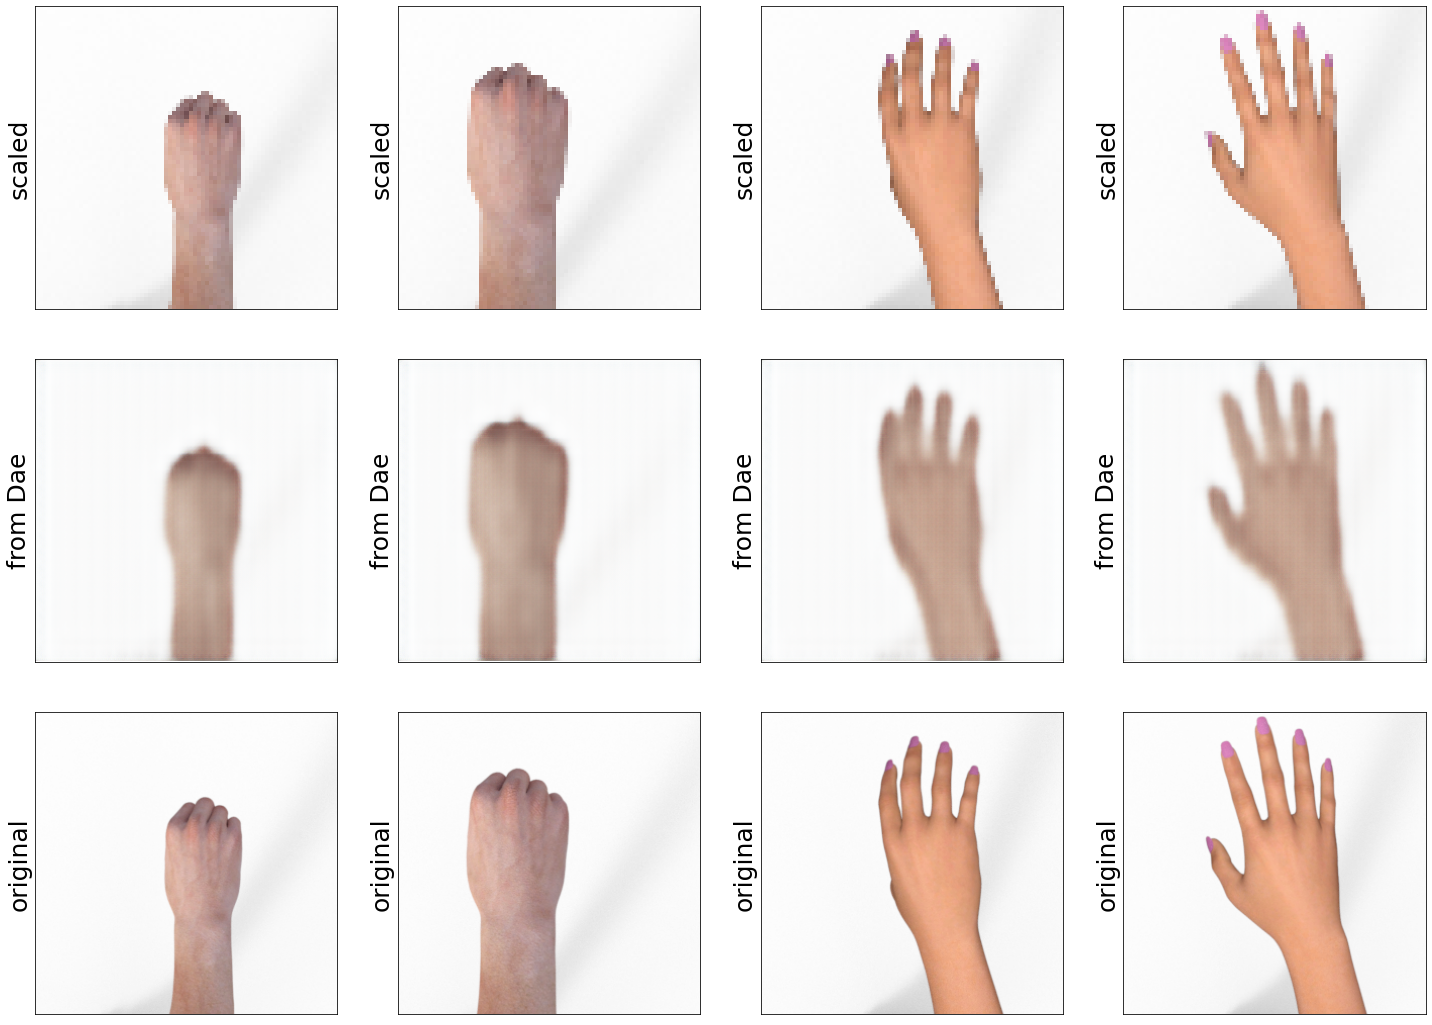

In [24]:
figure = plot_image_grid(
    [val_images_input.numpy(), val_images_pred, val_images_target.numpy()],
    titles=['scaled', 'from Dae', 'original'], transpose=True
)
figure.show()

In [0]:
from tensorflow.keras.layers import Dropout, MaxPooling2D, LeakyReLU, concatenate, BatchNormalization

In [0]:
def name_layer_factory(num=0, name_prefix="", name_suffix=""):
    """
    Helper function to name all our layers.
    """
    def name_layer_fn(layer):
        return '{}{}{}-{}'.format(name_prefix, layer, name_suffix, num)
    
    return name_layer_fn


def conv_bn_lrelu(filters, kernel_size=3, batch_norm=True,
                  kernel_initializer='he_normal', padding='same',
                  name_fn=lambda layer: "conv_bn_lrelu-{}".format(layer)):
    
    def block(x):
        x = Conv2D(filters, kernel_size=kernel_size, 
                   activation=None, kernel_initializer=kernel_initializer, 
                   padding=padding, name=name_fn('conv'))(x)
        if batch_norm:
            x = BatchNormalization(name=name_fn('bn'))(x)
        x = LeakyReLU(alpha=0.3, name=name_fn('act'))(x)
        return x
    
    return block


def unet_conv_block(filters, kernel_size=3,
                    batch_norm=True, dropout=False, 
                    name_prefix="enc_", name_suffix=0):
    
    def block(x):
        # First convolution:
        name_fn = name_layer_factory(1, name_prefix, name_suffix)
        x = conv_bn_lrelu(filters, kernel_size=kernel_size, batch_norm=batch_norm, 
                          name_fn=name_layer_factory(1, name_prefix, name_suffix))(x)
        if dropout:
            x = Dropout(0.2, name=name_fn('drop'))(x)

        # Second convolution:
        name_fn = name_layer_factory(2, name_prefix, name_suffix)
        x = conv_bn_lrelu(filters, kernel_size=kernel_size, batch_norm=batch_norm, 
                          name_fn=name_layer_factory(2, name_prefix, name_suffix))(x)

        return x
    
    return block

In [0]:
ResizeToSame = lambda name: Lambda(
    lambda images: tf.image.resize(images[0], tf.shape(images[1])[-3:-1]), 
    name=name)


def unet(x, layer_depth=4, filters_orig=32, kernel_size=4, 
         batch_norm=True, dropout=True, final_activation='sigmoid'):

    num_channels = x.shape[-1]
    
    filters = filters_orig
    outputs_for_skip = []
    for i in range(layer_depth):
        
        x_conv = unet_conv_block(filters, kernel_size, 
                                 dropout=dropout, batch_norm=batch_norm, 
                                 name_prefix="enc_", name_suffix=i)(x)
        
        outputs_for_skip.append(x_conv)

        x = MaxPooling2D(2)(x_conv)

        filters = min(filters * 2, 512)

    x = unet_conv_block(filters, kernel_size, dropout=dropout, 
                        batch_norm=batch_norm, name_suffix='_btleneck')(x)

    for i in range(layer_depth):
        filters = max(filters // 2, filters_orig)

        # Upsampling:
        name_fn = name_layer_factory(3, "ups_", i)
        x = Conv2DTranspose(filters, kernel_size=kernel_size, strides=2, 
                            activation=None, kernel_initializer='he_normal', 
                            padding='same', name=name_fn('convT'))(x)
        if batch_norm:
            x = BatchNormalization(name=name_fn('bn'))(x)
        x = LeakyReLU(alpha=0.3, name=name_fn('act'))(x)
    
        shortcut = outputs_for_skip[-(i + 1)]
        x = ResizeToSame(name='resize_to_same{}'.format(i))([x, shortcut])
        
        x = concatenate([x, shortcut], axis=-1, name='dec_conc{}'.format(i))

        use_dropout = dropout and (i < (layer_depth - 2))
        x = unet_conv_block(filters, kernel_size, 
                            batch_norm=batch_norm, dropout=use_dropout,
                            name_prefix="dec_", name_suffix=i)(x)

    x = Conv2D(filters=num_channels, kernel_size=1, activation=final_activation, 
               padding='same', name='dec_output')(x)
    
    return x

In [0]:
kernel_size  =  4
filters_orig = 32
layer_depth  =  4
use_batch_norm = BATCH_SIZE > 1

In [0]:
inputs = tf.keras.layers.Input(shape=(None, None, input_shape[-1]), name='input')
resized_inputs = Upscale(name='upscale_input')(inputs)
outputs = unet(resized_inputs, layer_depth, filters_orig, kernel_size, use_batch_norm)
unet_model = tf.keras.Model(inputs, outputs)

In [31]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),
]

psnr_metric = functools.partial(tf.image.psnr, max_val=1.)
psnr_metric.__name__ = 'psnr'

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
unet_model.compile(optimizer=optimizer, loss='mae', metrics=[psnr_metric])

unet_model.fit(
    train_hands_dataset, epochs=num_epochs, steps_per_epoch=train_steps_per_epoch,
    validation_data = val_hands_dataset, validation_steps=val_steps_per_epoch, 
    callbacks=callbacks
)

Train for 79 steps, validate for 12 steps
Epoch 1/100
79/79 [==============================] - 96s 1s/step - loss: 0.2291 - psnr: 12.0309 - val_loss: 0.4056 - val_psnr: 6.6202
Epoch 2/100
79/79 [==============================] - 83s 1s/step - loss: 0.1717 - psnr: 14.4312 - val_loss: 0.2053 - val_psnr: 13.1886
Epoch 3/100
79/79 [==============================] - 85s 1s/step - loss: 0.1559 - psnr: 15.1810 - val_loss: 0.1747 - val_psnr: 14.3998
Epoch 4/100
79/79 [==============================] - 84s 1s/step - loss: 0.1349 - psnr: 16.5086 - val_loss: 0.1470 - val_psnr: 15.8208
Epoch 5/100
79/79 [==============================] - 85s 1s/step - loss: 0.1243 - psnr: 17.2961 - val_loss: 0.1408 - val_psnr: 16.3471
Epoch 6/100
79/79 [==============================] - 84s 1s/step - loss: 0.1107 - psnr: 18.3029 - val_loss: 0.1282 - val_psnr: 16.9942
Epoch 7/100
79/79 [==============================] - 85s 1s/step - loss: 0.0941 - psnr: 19.6541 - val_loss: 0.1168 - val_psnr: 17.8176
Epoch 8/100
79

In [0]:
val_images_pred = unet_model.predict(val_images_input)

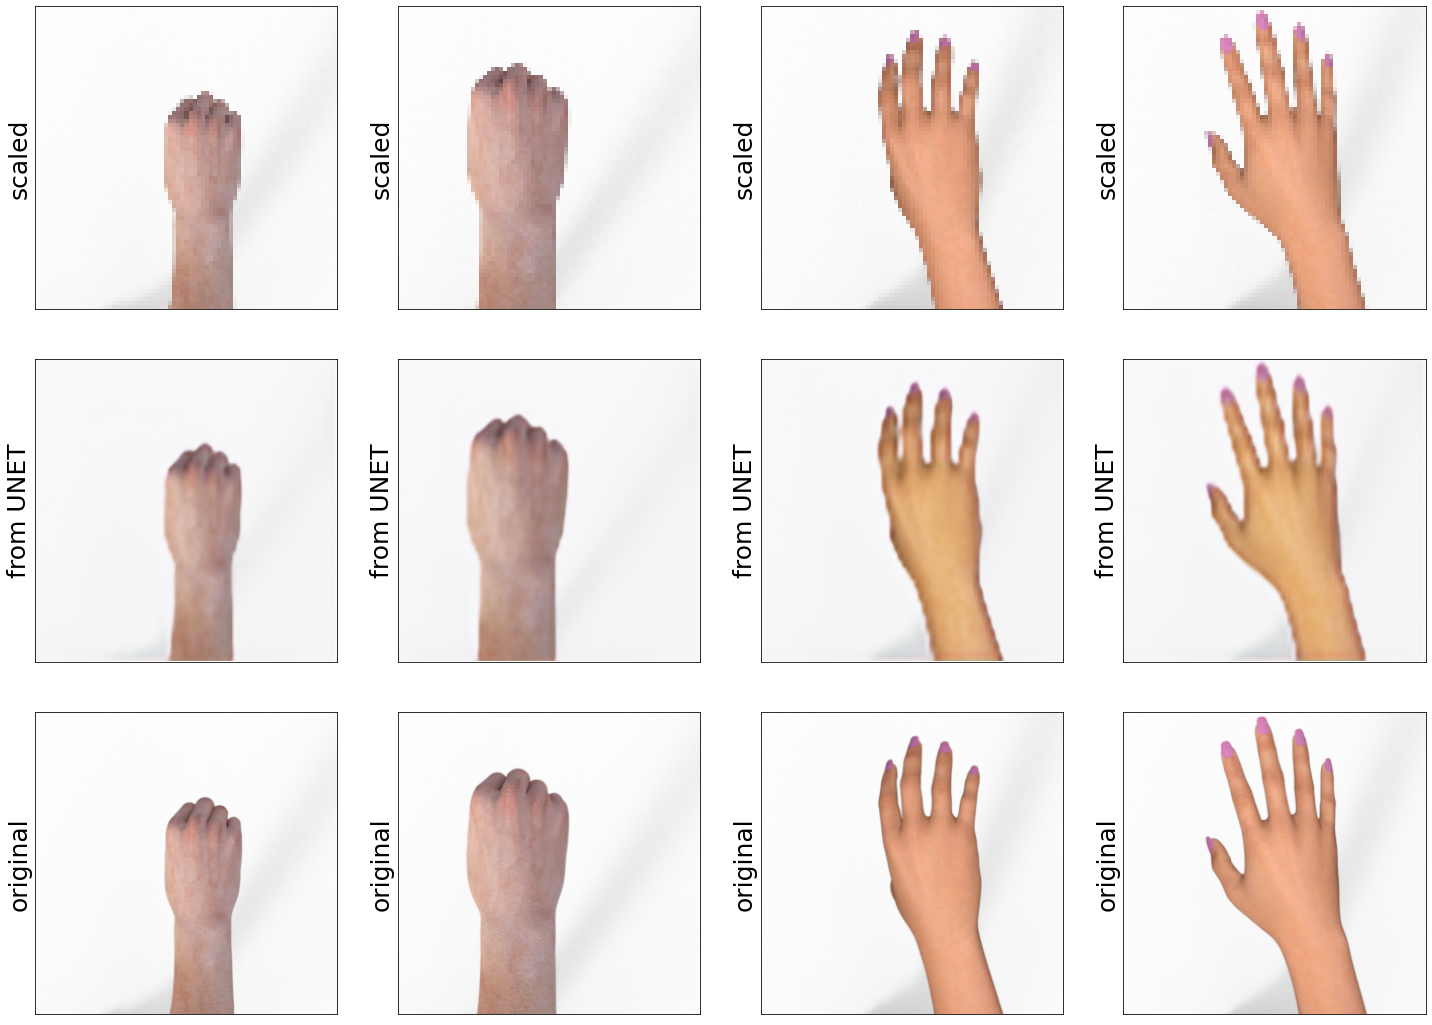

In [35]:
figure = plot_image_grid(
    [val_images_input.numpy(), val_images_pred, val_images_target.numpy()],
    titles=['scaled', 'from UNET', 'original'], transpose=True
)
figure.show()

In [0]:
unet_model.save('unet_model.h5')